In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data

In [3]:
# generate data for grid network (features and costs)
m = 16 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 3 # dimension of knapsack
cap = [10] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim)

In [4]:
weights

array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23],
       [6.11, 5.23, 4.27, 6.66, 5.21, 3.72, 7.83, 5.64, 7.56, 3.28, 4.31,
        3.85, 6.43, 4.26, 7.56, 6.4 ],
       [6.09, 6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27,
        4.55, 5.64, 5.66, 3.27, 6.68]])

## Optimization Model 

In [5]:
#ks_model = pyepo.model.omo.knapsackModel(weights, cap, solver="gurobi")
ks_model = pyepo.model.omo.knapsackModel(weights, cap, solver="glpk")

Solver in the background: glpk


In [6]:
# solve
ks_model.setObj([i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print("Obj: {}".format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Obj: 18.0
5
13


In [7]:
# relax
ks_model_rel = ks_model.relax()

Solver in the background: glpk


In [8]:
# solve
ks_model_rel.setObj([i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print("Obj: {}".format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75825065494684, 0.0, 0.913521784638344, 0.421842880409434, 0.0]
Obj: 26.12234073044579
11
13
14


## Data Loader 

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [10]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [11]:
# get training data set
ks_dataset_train = pyepo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.36it/s]


In [12]:
# get training data set for relaxation
ks_dataset_train_rel = pyepo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.26it/s]


In [13]:
# get test data set
ks_dataset_test = pyepo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.29it/s]


In [14]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [15]:
for i, data in enumerate(ks_loader_train): 
    x, c, w, z = data
    break

In [16]:
x.shape

torch.Size([32, 5])

In [17]:
c.shape

torch.Size([32, 16])

In [18]:
w.shape

torch.Size([32, 16])

In [19]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [22]:
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [23]:
# training
twostage_model.fit(ks_dataset_train.feats, ks_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [24]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.feats)

In [25]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += pyepo.metric.calRegret(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.metric.calUnambRegret(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print("Normalized Regret: {:.2f}%".format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print("Normalized Unambiguous Regret: {:.2f}%".format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:55<00:00,  5.70it/s]


Normalized Regret: 2.19%
Normalized Unambiguous Regret: 2.19%


In [26]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 1.00, 2.00, 2.00, 1.00, 2.00, 2.00, 1.00, 3.00, 2.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 2.00
    Pred cost: 0.41, 2.34, 1.81, 0.75, 2.72, 2.72, -0.02, 3.00, 1.67, 1.44, 1.81, 0.99, 2.72, 2.00, 2.16, 1.67
    True sol: 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, True obj: 4.00
    Pred sol: 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 4.00

Sample 1:
    True cost: 8.00, 12.00, 5.00, 13.00, 3.00, 3.00, 18.00, 3.00, 12.00, 7.00, 5.00, 12.00, 3.00, 8.00, 3.00, 12.00
    Pred cost: 7.39, 8.81, 5.99, 10.39, 3.77, 3.77, 11.57, 3.00, 8.53, 6.12, 5.99, 9.91, 3.77, 8.10, 4.12, 8.53
    True sol: 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 18.00
    Pred sol: 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 15.00

Sample 2:
    True cost: 7.00, 2.00, 5.00, 5.00, 5.00, 5.00, 5.00, 3.00, 3.00, 4.00, 5.00, 2.00, 5.00, 3.00, 4.00, 3.00
    Pred cost: 8.03, 1.69, 5.93, 7.02, 5.71, 5.71, 7.22, 3.00, 3.65, 4.95, 5.93, 3.41, 5.71, 4.79, 

## Linear Regression from PyTorch

In [27]:
from torch import nn

In [28]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [29]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [30]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [31]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [32]:
# train model
num_epochs = 200
reg.train()
loss_log = []
regret_log = []
unambregret_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = spop(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    if epoch % 10 == 0:
        # true regret
        regret = pyepo.metric.regret(reg, ks_model, ks_loader_test)
        regret_log.append(regret)
        # unambiguous regret 
        unambregret = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
        unambregret_log.append(unambregret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch, loss.item(), regret*100, unambregret*100))

Epoch   0, Loss:  20.2324, Regret: 51.8565%, Unambiguous Regret: 51.8565%
Epoch  10, Loss:   5.6085, Regret: 20.4210%, Unambiguous Regret: 20.4210%
Epoch  20, Loss:   7.2303, Regret:  7.9321%, Unambiguous Regret:  7.9321%
Epoch  30, Loss:   3.6267, Regret:  4.6278%, Unambiguous Regret:  4.6278%
Epoch  40, Loss:  10.6098, Regret:  3.5353%, Unambiguous Regret:  3.5353%
Epoch  50, Loss:   4.0132, Regret:  3.0734%, Unambiguous Regret:  3.0734%
Epoch  60, Loss:   0.3413, Regret:  2.6470%, Unambiguous Regret:  2.6470%
Epoch  70, Loss:  -0.0000, Regret:  2.1762%, Unambiguous Regret:  2.1762%
Epoch  80, Loss:   0.8968, Regret:  1.7232%, Unambiguous Regret:  1.7232%
Epoch  90, Loss:   1.4864, Regret:  1.4479%, Unambiguous Regret:  1.4479%
Epoch 100, Loss:   0.9572, Regret:  1.3324%, Unambiguous Regret:  1.3324%
Epoch 110, Loss:   0.2184, Regret:  1.4123%, Unambiguous Regret:  1.4123%
Epoch 120, Loss:   0.6577, Regret:  1.3146%, Unambiguous Regret:  1.3146%
Epoch 130, Loss:   0.5289, Regret:  1.

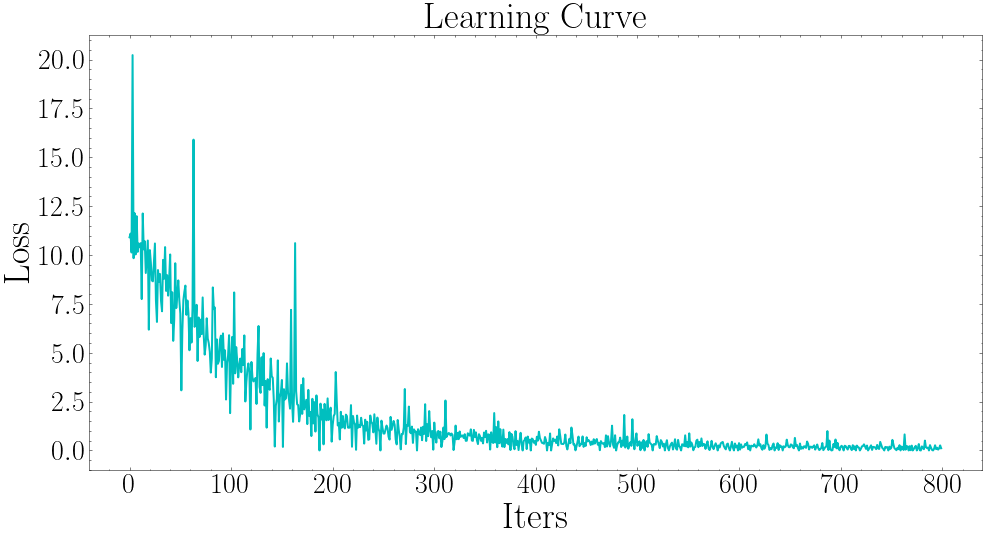

In [33]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

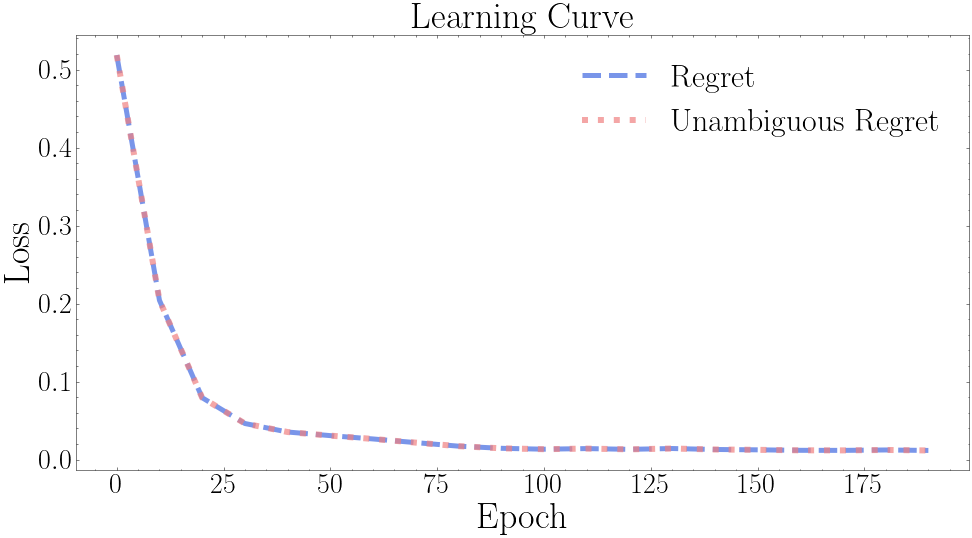

In [34]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 10), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 10), unambregret_log, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [35]:
# evaluate
regret = pyepo.metric.regret(reg, ks_model, ks_loader_test)
print("Normalized Regret: {:.2f}%".format(regret * 100))
regret = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(regret * 100))

Normalized Regret: 1.19%
Normalized Unambiguous Regret: 1.19%


In [36]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 1.00, 2.00, 2.00, 1.00, 2.00, 2.00, 1.00, 3.00, 2.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 2.00
    Pred cost: -2.64, 0.40, 0.30, -2.24, 0.43, 2.33, -3.50, 2.72, -0.48, 1.80, 0.99, -1.27, -0.32, 1.07, 0.47, 0.39
    True sol: 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, True obj: 4.00
    Pred sol: 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, Pred obj: 4.00

Sample 1:
    True cost: 8.00, 12.00, 5.00, 13.00, 3.00, 3.00, 18.00, 3.00, 12.00, 7.00, 5.00, 12.00, 3.00, 8.00, 3.00, 12.00
    Pred cost: 3.61, 6.39, -0.12, 7.11, -0.51, 2.77, 10.50, -1.04, 1.07, 0.69, 0.76, 4.98, 0.43, 3.54, -1.12, 5.34
    True sol: 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 18.00
    Pred sol: 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 18.00

Sample 2:
    True cost: 7.00, 2.00, 5.00, 5.00, 5.00, 5.00, 5.00, 3.00, 3.00, 4.00, 5.00, 2.00, 5.00, 3.00, 4.00, 3.00
    Pred cost: 5.20, -2.03, -0.49, 3.44, -0.19, 4.23, 3.11, 1.27, -0.52, 2.36, 3.31, -2.37,

## SPO+ Rel 

In [37]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [38]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [39]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(ks_model_rel, processes=4)

Num of cores: 4


In [40]:
# train model
num_epochs = 200
reg.train()
loss_log = []
regret_log = []
unambregret_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = spop(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    if epoch % 10 == 0:
        # true regret
        regret = pyepo.metric.regret(reg, ks_model, ks_loader_test)
        regret_log.append(regret)
        # unambiguous regret 
        unambregret = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
        unambregret_log.append(unambregret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch, loss.item(), regret*100, unambregret*100))

Epoch   0, Loss:  10.6394, Regret: 51.0926%, Unambiguous Regret: 51.0926%
Epoch  10, Loss:   3.3179, Regret: 12.7465%, Unambiguous Regret: 12.7465%
Epoch  20, Loss:  18.6558, Regret:  6.7152%, Unambiguous Regret:  6.7152%
Epoch  30, Loss:   6.8176, Regret:  4.0593%, Unambiguous Regret:  4.0593%
Epoch  40, Loss:   0.5977, Regret:  3.4642%, Unambiguous Regret:  3.4642%
Epoch  50, Loss:   0.7527, Regret:  3.2155%, Unambiguous Regret:  3.2155%
Epoch  60, Loss:   0.6627, Regret:  2.9579%, Unambiguous Regret:  2.9579%
Epoch  70, Loss:   2.4217, Regret:  2.7269%, Unambiguous Regret:  2.7269%
Epoch  80, Loss:   0.4713, Regret:  2.6026%, Unambiguous Regret:  2.6026%
Epoch  90, Loss:   0.3417, Regret:  2.4516%, Unambiguous Regret:  2.4516%
Epoch 100, Loss:   0.3302, Regret:  2.3539%, Unambiguous Regret:  2.3539%
Epoch 110, Loss:   0.2541, Regret:  2.1496%, Unambiguous Regret:  2.1496%
Epoch 120, Loss:   0.1925, Regret:  2.0430%, Unambiguous Regret:  2.0430%
Epoch 130, Loss:   0.1178, Regret:  1.

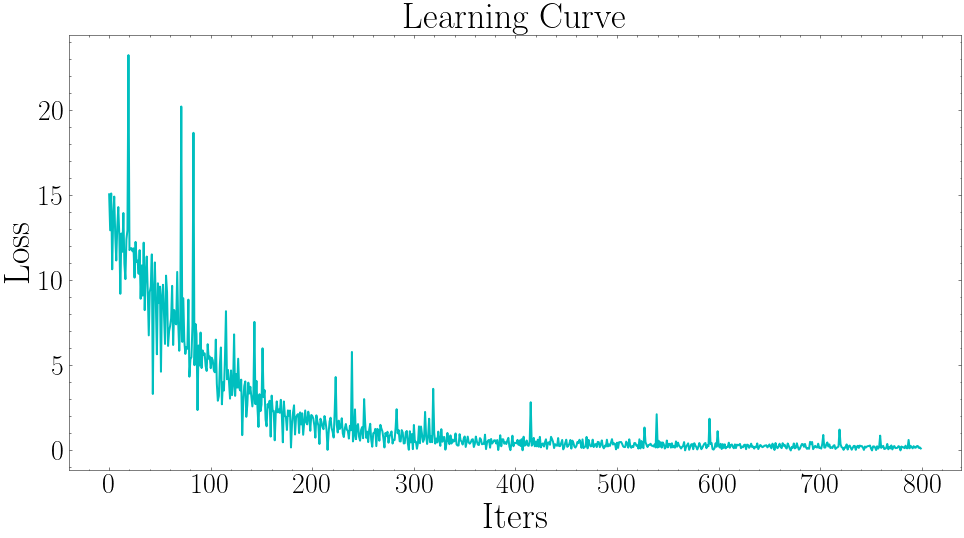

In [41]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

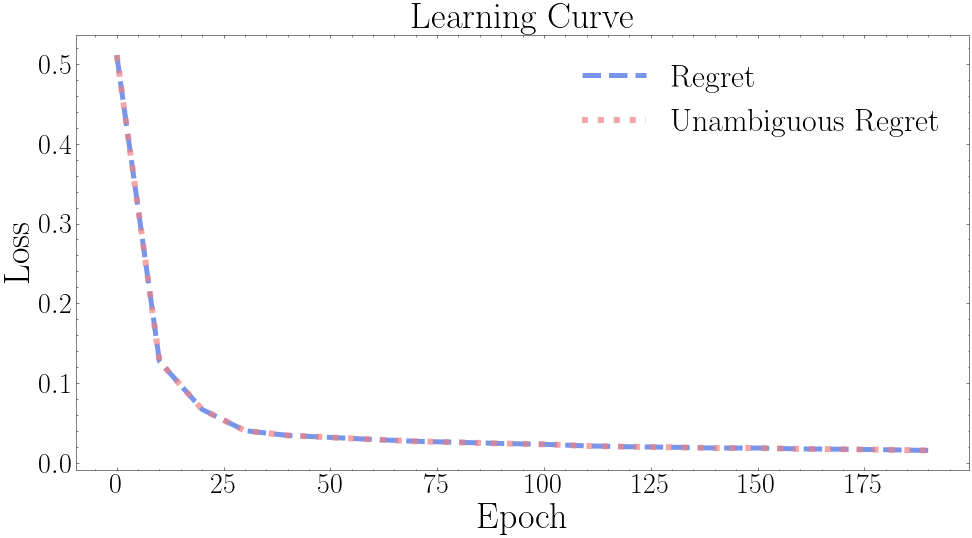

In [42]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 10), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 10), unambregret_log, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [43]:
# evaluate
regret = pyepo.metric.regret(reg, ks_model, ks_loader_test)
print("Normalized Regret: {:.2f}%".format(regret * 100))
regret = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(regret * 100))

Normalized Regret: 1.71%
Normalized Unambiguous Regret: 1.71%


In [44]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 1.00, 2.00, 2.00, 1.00, 2.00, 2.00, 1.00, 3.00, 2.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 2.00
    Pred cost: -1.89, -0.16, 0.67, -2.52, 2.08, 2.68, -4.17, 2.75, -0.36, 0.87, 0.63, -1.32, 2.12, 0.67, 1.88, -0.42
    True sol: 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, True obj: 4.00
    Pred sol: 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, Pred obj: 4.00

Sample 1:
    True cost: 8.00, 12.00, 5.00, 13.00, 3.00, 3.00, 18.00, 3.00, 12.00, 7.00, 5.00, 12.00, 3.00, 8.00, 3.00, 12.00
    Pred cost: 3.92, 6.98, 2.53, 5.65, -3.34, 0.41, 9.92, -2.98, 7.30, 2.66, 2.46, 7.10, -2.69, 3.84, 0.73, 5.94
    True sol: 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 18.00
    Pred sol: 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 18.00

Sample 2:
    True cost: 7.00, 2.00, 5.00, 5.00, 5.00, 5.00, 5.00, 3.00, 3.00, 4.00, 5.00, 2.00, 5.00, 3.00, 4.00, 3.00
    Pred cost: 5.78, -2.12, 4.16, 3.86, 2.92, 3.55, 3.08, 0.48, 1.40, 3.17, 4.02, 0.18, 2.21